# Confidence Interval Test for Confined Aquifers
**Synthetic data**

In [1]:
%matplotlib inline
import ttim
from ttim import *
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import integrate

In [2]:
ttim.__version__

'0.6.0'

Set basic parameters for the model:

In [3]:
H = 7 #aquifer thickness
k = 70 #hydraulic conductivity
S = 1e-4 #specific storage
Q = 788 #constant discharge
d1 = 30 #observation well 1
d2 = 90 #observation well 2 (positions same as for Oude Korendijk)

Load data of test site 'Oude Korendijk':

In [4]:
data1 = np.loadtxt('Piezometer H30.txt', skiprows = 1)
t = data1[:, 0] / 60 / 24 # time [s]

Create conceptual model:

In [5]:
ml = ModelMaq(kaq = 70, z = (-18, -25), Saq = 1e-4, tmin = 1e-5, tmax = 1)
w = Well(ml, xw = 0, yw = 0, rw = 0.1, tsandQ = [(0, 788)])
ml.solve(silent = 'True')
h1 = ml.head(d1, 0, t)
h2 = ml.head(d2, 0, t)

Add noises:

In [6]:
import random
from random import choice

In [7]:
np.savetxt('Syn P30 0.0.txt', h1[0])
np.savetxt('Syn P90 0.0.txt', h2[0])
#print(h2[0])

In [8]:
np.random.seed(5)
he12 = h1[0] - np.random.randn(len(t))*0.02
he22 = h2[0] - np.random.randn(len(t))*0.02
np.savetxt('Syn P30 0.02.txt', he12)
np.savetxt('Syn P90 0.02.txt', he22)

In [9]:
np.random.seed(4)
he15 = h1[0] - np.random.randn(len(t)) * 0.05
he25 = h2[0] - np.random.randn(len(t)) * 0.05
np.savetxt('Syn P30 0.05.txt', he15)
np.savetxt('Syn P90 0.05.txt', he25)

In [10]:
np.random.seed(6)
he10 = h1[0] - np.random.randn(len(t)) * 0.1
he20 = h2[0] - np.random.randn(len(t)) * 0.1
np.savetxt('Syn P30 0.1.txt', he10)
np.savetxt('Syn P90 0.1.txt', he20)

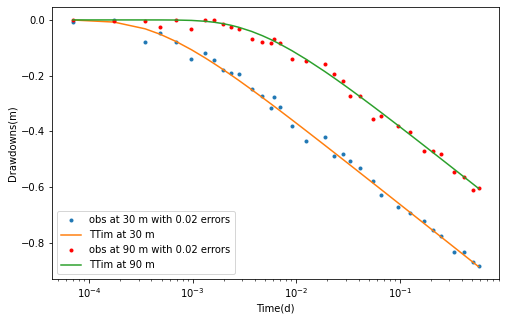

In [11]:
plt.figure(figsize = (8, 5))
plt.semilogx(t, he12, 'o', markersize = 3, label = 'obs at 30 m with 0.02 errors')
plt.semilogx(t, h1[0], label = 'TTim at 30 m')
plt.semilogx(t, he22, 'ro', markersize = 3, label = 'obs at 90 m with 0.02 errors')
plt.semilogx(t, h2[0], label = 'TTim at 90 m')
plt.legend(loc = 'best')
plt.xlabel('Time(d)')
plt.ylabel('Drawdowns(m)');

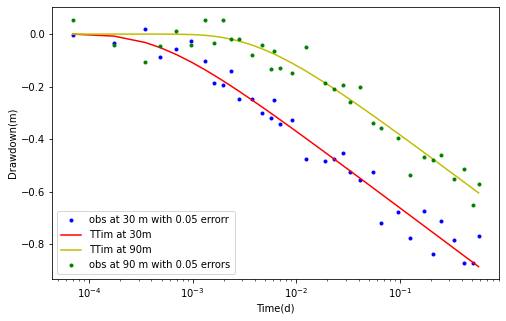

In [12]:
plt.figure(figsize = (8, 5))
plt.semilogx(t, he15, 'bo',markersize = 3, label = 'obs at 30 m with 0.05 errorr')
plt.semilogx(t, h1[0], 'r',label = 'TTim at 30m')
plt.semilogx(t, h2[0], 'y', label = 'TTim at 90m')
plt.semilogx(t, he25, 'go', markersize = 3, label = 'obs at 90 m with 0.05 errors')
plt.xlabel('Time(d)')
plt.ylabel('Drawdown(m)')
plt.legend(loc = 'best');

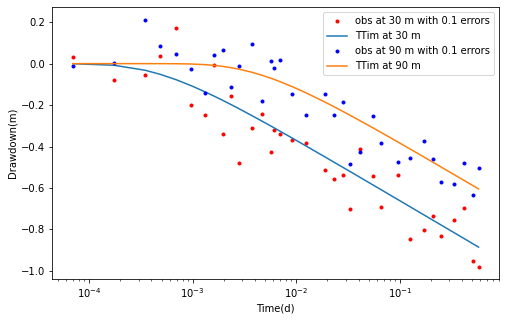

In [13]:
plt.figure(figsize = (8, 5))
plt.semilogx(t, he10, 'ro', markersize = 3, label = 'obs at 30 m with 0.1 errors')
plt.semilogx(t, h1[0], label = 'TTim at 30 m')
plt.semilogx(t, he20, 'bo', markersize = 3, label = 'obs at 90 m with 0.1 errors')
plt.semilogx(t, h2[0], label = 'TTim at 90 m')
plt.legend(loc = 'best')
plt.xlabel('Time(d)')
plt.ylabel('Drawdown(m)');

In [14]:
#hAQ0 = h1[0]
#np.savetxt('Syn P30 0.0 (AQ).txt', np.column_stack((t, hAQ0)))
#hAQ09 = h2[0]
#np.savetxt('Syn P90 0.0 (AQ).txt', np.column_stack((t, hAQ09)))

#### Fit with Theim's method

In [15]:
sm1 = - h1[0, -1]
sm2 = - h2[0, -1]
def Steady(Q, r1, r2, sm1, sm2):
    KD = Q * 2.3 * (math.log(r2/r1, 10)) / 2 / math.pi / (sm1-sm2)
    return KD
KD0 = Steady(Q, d1, d2, sm1, sm2)
print(round(KD0 / H, 3))

70.063


In [16]:
sm12 = - he12[-1]
sm22 = - he22[-1]
def Steady(Q, r1, r2, sm1, sm2):
    KD = Q * 2.3 * (math.log(r2/r1, 10)) / 2 / math.pi / (sm1-sm2)
    return KD
KD2 = Steady(Q, d1, d2, sm12, sm22)
print(round(KD2 / H, 3))

70.201


In [17]:
sm15 = - he15[-1]
sm25 = - he25[-1]
def Steady(Q, r1, r2, sm1, sm2):
    KD = Q * 2.3 * (math.log(r2/r1, 10)) / 2 / math.pi / (sm1-sm2)
    return KD
KD5 = Steady(Q, d1, d2, sm15, sm25)
print(round(KD5 / H, 3))

100.776


In [18]:
sm10 = - he10[-1]
sm20 = - he20[-1]
def Steady(Q, r1, r2, sm1, sm2):
    KD = Q * 2.3 * (math.log(r2/r1, 10)) / 2 / math.pi / (sm1-sm2)
    return KD
KD10 = Steady(Q, d1, d2, sm10, sm20)
print(round(KD10 / H, 3))

41.271


#### Test if TTim find the parameters back:

Calibrate with two datasets respectively (0.02):

In [19]:
ca23 = Calibrate(ml)
ca23.set_parameter(name = 'kaq0', initial = 10)
ca23.set_parameter(name = 'Saq0', initial = 1e-3)
ca23.series(name = 'obs1', x = d1, y = 0, t = t, h = he12, layer = 0)
ca23.fit(report = True)
display(ca23.parameters)

...........................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24
    # data points      = 34
    # variables        = 2
    chi-square         = 0.01117172
    reduced chi-square = 3.4912e-04
    Akaike info crit   = -268.704816
    Bayesian info crit = -265.652095
[[Variables]]
    kaq0:  69.9137850 +/- 1.09422440 (1.57%) (init = 10)
    Saq0:  1.0171e-04 +/- 5.4839e-06 (5.39%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.852


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,69.9138,1.094224,1.56511,-inf,inf,10,[69.91378501112042]
Saq0,0.000101707,0.000005,5.39186,-inf,inf,0.001,[0.00010170651963360881]


rmse: 0.018126778807417847


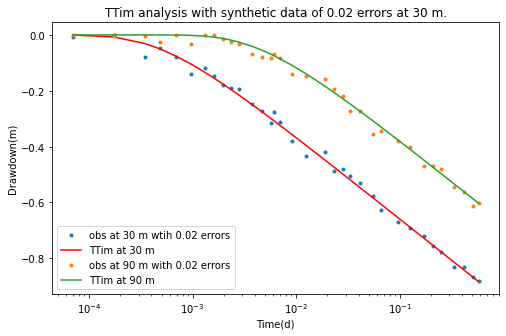

In [20]:
print('rmse:', ca23.rmse())
h123 = ml.head(d1, 0, t)
h223 = ml.head(d2, 0 ,t)
plt.figure(figsize = (8, 5))
plt.semilogx(t, he12, 'o', markersize = 3, label = 'obs at 30 m wtih 0.02 errors')
plt.semilogx(t, h123[0], color = 'r', label = 'TTim at 30 m')
plt.semilogx(t, he22, 'o', markersize = 3, label = 'obs at 90 m with 0.02 errors')
plt.semilogx(t, h223[0], label = 'TTim at 90 m')
plt.xlabel('Time(d)')
plt.ylabel('Drawdown(m)')
plt.title('TTim analysis with synthetic data of 0.02 errors at 30 m.')
plt.legend(loc = 'best');

In [21]:
ca29 = Calibrate(ml)
ca29.set_parameter(name = 'kaq0', initial = 10)
ca29.set_parameter(name = 'Saq0', initial = 1e-3)
ca29.series(name = 'obs2', x = d2, y = 0, t = t, h = he22, layer = 0)
ca29.fit(report = True)
display(ca29.parameters)

.........................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 34
    # variables        = 2
    chi-square         = 0.00859548
    reduced chi-square = 2.6861e-04
    Akaike info crit   = -277.617896
    Bayesian info crit = -274.565175
[[Variables]]
    kaq0:  70.7905262 +/- 1.71072779 (2.42%) (init = 10)
    Saq0:  9.3336e-05 +/- 5.1366e-06 (5.50%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.831


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,70.7905,1.710728,2.41661,-inf,inf,10,[70.79052617053115]
Saq0,9.3336e-05,0.000005,5.50339,-inf,inf,0.001,[9.333599897871232e-05]


rmse: 0.0158999446543865


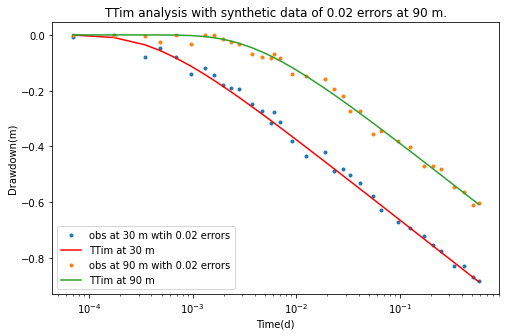

In [22]:
print('rmse:', ca29.rmse())
h129 = ml.head(d1, 0, t)
h229 = ml.head(d2, 0, t)
plt.figure(figsize = (8, 5))
plt.semilogx(t, he12, 'o', markersize = 3, label = 'obs at 30 m wtih 0.02 errors')
plt.semilogx(t, h129[0], color = 'r', label = 'TTim at 30 m')
plt.semilogx(t, he22, '.', label = 'obs at 90 m with 0.02 errors')
plt.semilogx(t, h229[0], label = 'TTim at 90 m')
plt.xlabel('Time(d)')
plt.ylabel('Drawdown(m)')
plt.title('TTim analysis with synthetic data of 0.02 errors at 90 m.')
plt.legend(loc = 'best');

#### Calibrate with two datasets simultaneously:

Drawdowns without errors:

In [23]:
ca0 = Calibrate(ml)
ca0.set_parameter(name = 'kaq0', initial = 10)
ca0.set_parameter(name = 'Saq0', initial = 1e-3)
ca0.series(name = 'obs1', x = d1, y = 0, t = t, h = h1[0], layer = 0)
ca0.series(name = 'obs2', x = d2, y = 0, t = t, h = h2[0], layer = 0)
ca0.fit(report = True)
display(ca0.parameters)

............................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 68
    # variables        = 2
    chi-square         = 5.2951e-15
    reduced chi-square = 8.0229e-17
    Akaike info crit   = -2518.22234
    Bayesian info crit = -2513.78333
[[Variables]]
    kaq0:  70.0000001 +/- 4.3464e-07 (0.00%) (init = 10)
    Saq0:  1.0000e-04 +/- 1.8824e-12 (0.00%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.830


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,70,4.346403e-07,6.20915e-07,-inf,inf,10,[70.00000014401469]
Saq0,0.0001,1.882424e-12,1.88242e-06,-inf,inf,0.001,[9.999999619860247e-05]


rmse: 8.824335776785093e-09


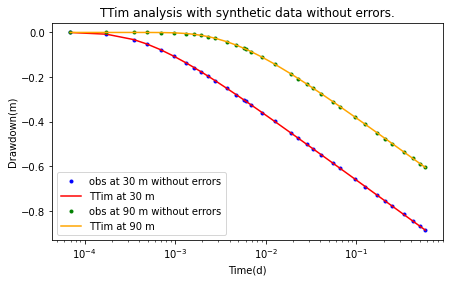

In [24]:
print('rmse:', ca0.rmse())
h1n = ml.head(d1, 0, t)
h2n = ml.head(d2, 0, t)
plt.figure(figsize = (7, 4))
plt.semilogx(t, h1[0], 'b.', label = 'obs at 30 m without errors')
plt.semilogx(t, h1n[0], color = 'r', label = 'TTim at 30 m')
plt.semilogx(t, h2[0], 'g.', label = 'obs at 90 m without errors')
plt.semilogx(t, h2n[0], color = 'orange', label = 'TTim at 90 m')
plt.xlabel('Time(d)')
plt.ylabel('Drawdown(m)')
plt.title('TTim analysis with synthetic data without errors.')
plt.legend(loc = 'best');

Drawdowns with +/- 0.02 errors:

In [25]:
ca2 = Calibrate(ml)
ca2.set_parameter(name = 'kaq0', initial = 10)
ca2.set_parameter(name = 'Saq0', initial = 1e-3)
ca2.series(name = 'obs1', x = d1, y = 0, t = t, h = he12, layer = 0)
ca2.series(name = 'obs2', x = d2, y = 0, t = t, h = he22, layer = 0)
ca2.fit(report = True)
display(ca2.parameters)

.............................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 68
    # variables        = 2
    chi-square         = 0.02036601
    reduced chi-square = 3.0858e-04
    Akaike info crit   = -547.710906
    Bayesian info crit = -543.271891
[[Variables]]
    kaq0:  70.5087598 +/- 0.85773411 (1.22%) (init = 10)
    Saq0:  9.7105e-05 +/- 3.6049e-06 (3.71%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.830


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,70.5088,0.857734,1.21649,-inf,inf,10,[70.50875979688288]
Saq0,9.71051e-05,0.000004,3.71232,-inf,inf,0.001,[9.710512364852172e-05]


rmse: 0.017306072293457823


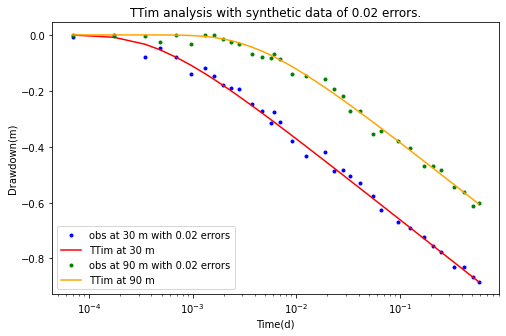

In [26]:
print('rmse:', ca2.rmse())
h12 = ml.head(d1, 0, t)
h22 = ml.head(d2, 0, t)
plt.figure(figsize = (8, 5))
plt.semilogx(t, he12, 'b.', label = 'obs at 30 m with 0.02 errors')
plt.semilogx(t, h12[0], color = 'r', label = 'TTim at 30 m')
plt.semilogx(t, he22, 'g.', label = 'obs at 90 m with 0.02 errors')
plt.semilogx(t, h22[0], color = 'orange', label = 'TTim at 90 m')
plt.xlabel('Time(d)')
plt.ylabel('Drawdown(m)')
plt.title('TTim analysis with synthetic data of 0.02 errors.')
plt.legend(loc = 'best');

Drawdowns wtih +/- 0.05 errors:

In [27]:
ca5 = Calibrate(ml)
ca5.set_parameter(name = 'kaq0', initial = 10)
ca5.set_parameter(name = 'Saq0', initial = 1e-3)
ca5.series(name = 'obs1', x = d1, y = 0, t = t, h = he15, layer = 0)
ca5.series(name = 'obs2', x = d2, y = 0, t = t, h = he25, layer = 0)
ca5.fit(report = True)
display(ca5.parameters)

.........................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 68
    # variables        = 2
    chi-square         = 0.16477219
    reduced chi-square = 0.00249655
    Akaike info crit   = -405.543539
    Bayesian info crit = -401.104524
[[Variables]]
    kaq0:  70.3174092 +/- 2.43429896 (3.46%) (init = 10)
    Saq0:  9.8233e-05 +/- 1.0351e-05 (10.54%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.830


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,70.3174,2.434299,3.46187,-inf,inf,10,[70.31740919987374]
Saq0,9.82329e-05,0.000010,10.5375,-inf,inf,0.001,[9.82329193800196e-05]


rmse: 0.049225201913026075


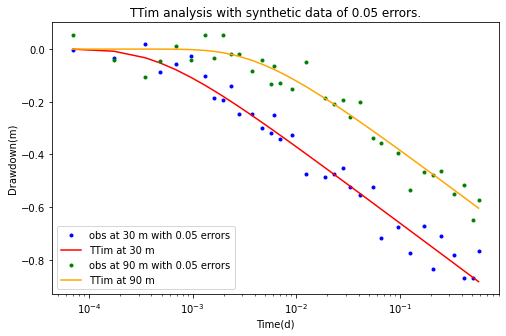

In [28]:
print('rmse:', ca5.rmse())
h15 = ml.head(d1, 0, t)
h25 = ml.head(d2, 0, t)
plt.figure(figsize = (8, 5))
plt.semilogx(t, he15, 'b.', label = 'obs at 30 m with 0.05 errors')
plt.semilogx(t, h15[0], color = 'r', label = 'TTim at 30 m')
plt.semilogx(t, he25, 'g.', label = 'obs at 90 m with 0.05 errors')
plt.semilogx(t, h25[0], color = 'orange', label = 'TTim at 90 m')
plt.xlabel('Time(d)')
plt.ylabel('Drawdown(m)')
plt.title('TTim analysis with synthetic data of 0.05 errors.')
plt.legend(loc = 'best');

Drawdowns wtih +/- 0.1 errors:

In [29]:
ca10 = Calibrate(ml)
ca10.set_parameter(name = 'kaq0', initial = 10)
ca10.set_parameter(name = 'Saq0', initial = 1e-3)
ca10.series(name = 'obs1', x = d1, y = 0, t = t, h = he10, layer = 0)
ca10.series(name = 'obs2', x = d2, y = 0, t = t, h = he20, layer = 0)
ca10.fit(report = True)
display(ca10.parameters)

.........................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 68
    # variables        = 2
    chi-square         = 0.66851557
    reduced chi-square = 0.01012902
    Akaike info crit   = -310.309824
    Bayesian info crit = -305.870808
[[Variables]]
    kaq0:  71.1840121 +/- 4.79769329 (6.74%) (init = 10)
    Saq0:  8.0602e-05 +/- 1.7164e-05 (21.29%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.833


,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,71.184,4.797693,6.73985,-inf,inf,10,[71.1840121074488]
Saq0,8.06018e-05,0.000017,21.2944,-inf,inf,0.001,[8.060179148807764e-05]


rmse: 0.09915196108334731


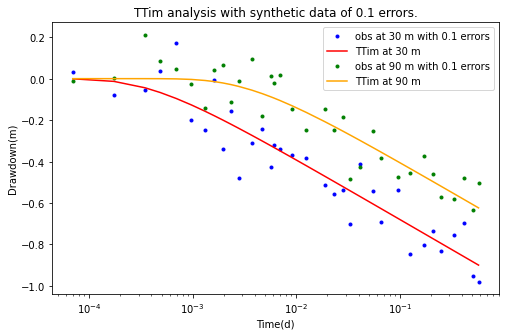

In [30]:
print('rmse:', ca10.rmse())
h10 = ml.head(d1, 0, t)
h20 = ml.head(d2, 0, t)
plt.figure(figsize = (8, 5))
plt.semilogx(t, he10, 'b.', label = 'obs at 30 m with 0.1 errors')
plt.semilogx(t, h10[0], color = 'r', label = 'TTim at 30 m')
plt.semilogx(t, he20, 'g.', label = 'obs at 90 m with 0.1 errors')
plt.semilogx(t, h20[0], color = 'orange', label = 'TTim at 90 m')
plt.xlabel('Time(d)')
plt.ylabel('Drawdown(m)')
plt.title('TTim analysis with synthetic data of 0.1 errors.')
plt.legend(loc = 'best');